In [1]:
#02/06/2025
### data analysis of metastatic LN

import scanpy as sc
import anndata as ad
import numpy as np
import bbknn
import pandas as pd
import glob
import os

c:\Users\jh9u24\AppData\Local\r-miniconda\envs\sctoolkit_3.12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### load in h5ad objects
OAC_pt = sc.read("C:/Users/jh9u24/OneDrive - University of Southampton/University/MRes/RPC/OAC_sc_data/Primary Tumour/OAC_pt.h5ad")

c:\Users\jh9u24\AppData\Local\r-miniconda\envs\sctoolkit_3.12\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
### Set parameters here 
npcs = 20
hvgs = 2500
res = 0.7
mindist = 0.3

In [4]:
### Normalisation  
# remove all NaNs
OAC_pt.X = np.nan_to_num(OAC_pt.X)
# save raw count data 
# Saving count data
OAC_pt.layers["counts"] = OAC_pt.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(OAC_pt)
# Logarithmize the data
sc.pp.log1p(OAC_pt)
# freeze the state in '.raw'
OAC_pt.raw = OAC_pt


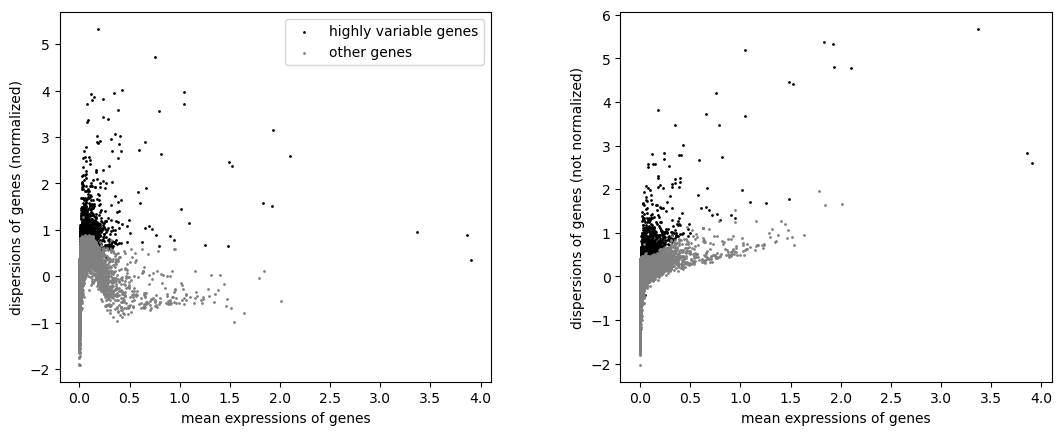

In [5]:
### Feature selection 
sc.pp.highly_variable_genes(OAC_pt, n_top_genes=hvgs, batch_key="sample")
sc.pl.highly_variable_genes(OAC_pt)
# actually filtering 
OAC_pt = OAC_pt[:, OAC_pt.var.highly_variable]
# to return to the anndata object prefiltering this is the rescue code
# adata.raw.to_adata()

c:\Users\jh9u24\AppData\Local\r-miniconda\envs\sctoolkit_3.12\Lib\site-packages\scanpy\preprocessing\_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\jh9u24\AppData\Local\r-miniconda\envs\sctoolkit_3.12\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\jh9u24\AppData\Local\r-miniconda\envs\sctoolkit_3.12\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


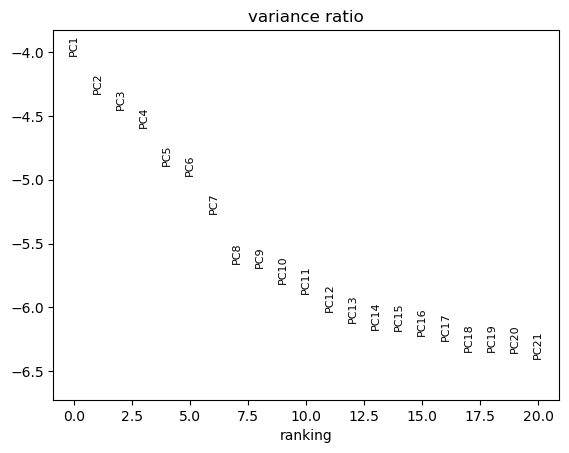

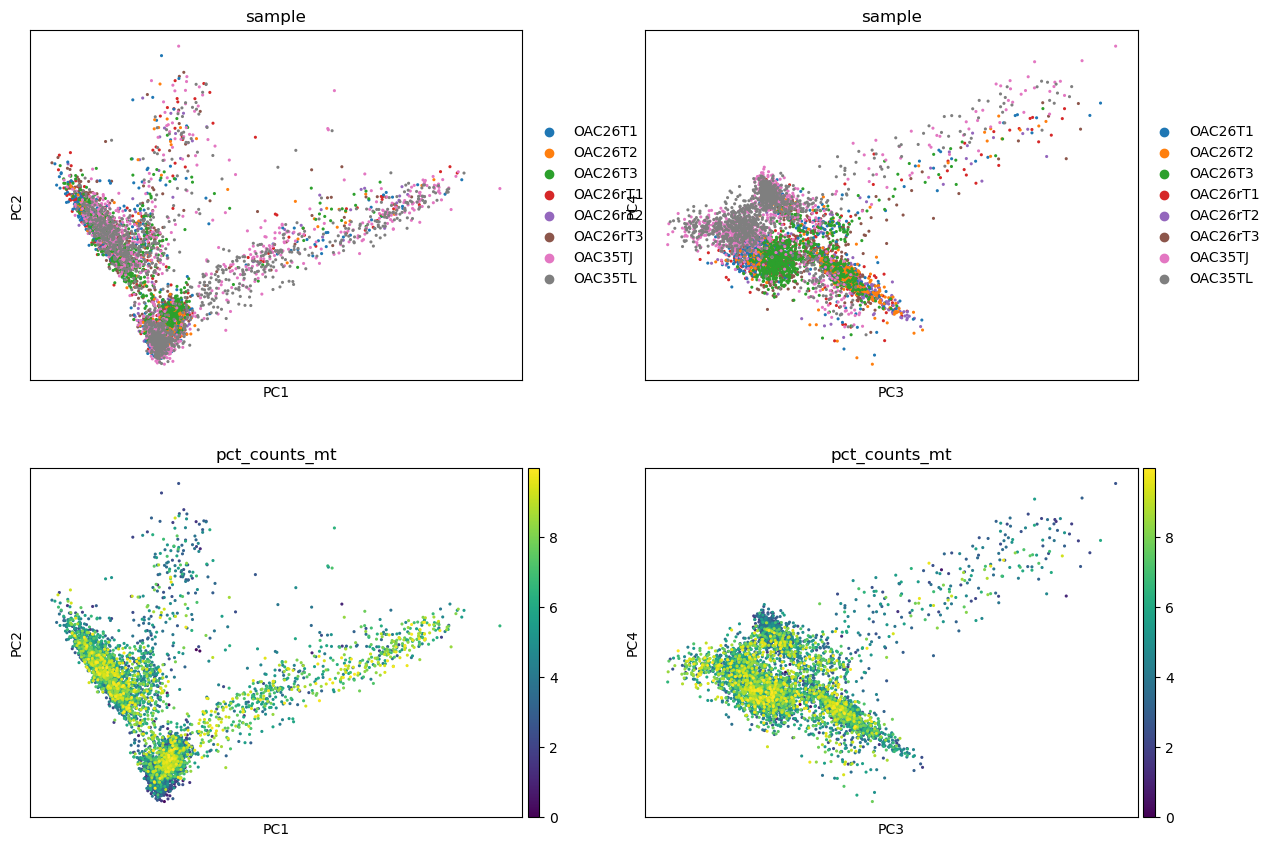

In [6]:
### Dimensionalilty reduction (PCA)
sc.pp.scale(OAC_pt)
sc.tl.pca(OAC_pt)
sc.pl.pca_variance_ratio(OAC_pt, n_pcs=npcs, log=True)
sc.pl.pca(
    OAC_pt,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=20,
)

In [7]:
### BBKNN 
# batch correction 
# bbknn
sc.external.pp.bbknn(OAC_pt, batch_key="sample", n_pcs=npcs)

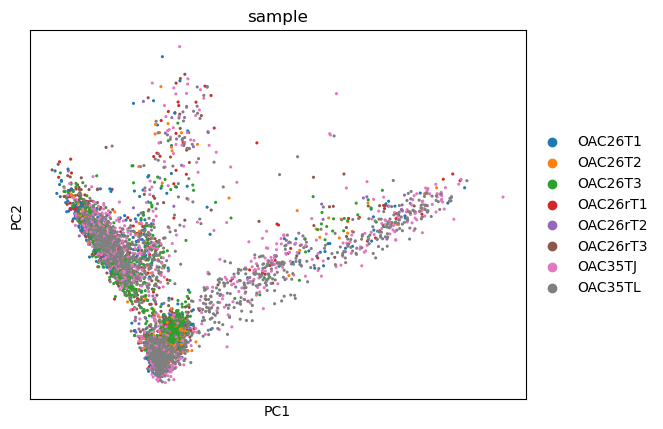

In [8]:
### PCA plot post batch correction 
sc.pl.pca(OAC_pt, color=["sample"], dimensions=[(0, 1)], ncols=2, size=20,)

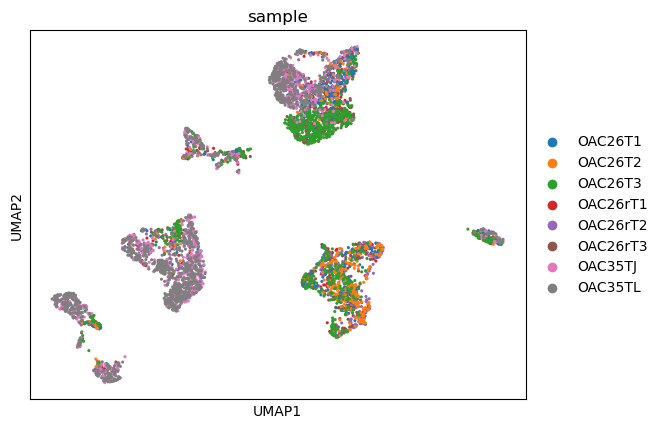

In [9]:
### Nearest neighbour graph
# sc.pp.neighbors(OAC_pt) ### this is not required if running bbknn
sc.tl.umap(OAC_pt, min_dist=mindist)
sc.pl.umap(
    OAC_pt,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=20,
)

C:\Users\jh9u24\AppData\Local\Temp\ipykernel_17160\3243086991.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(OAC_pt, resolution=res)


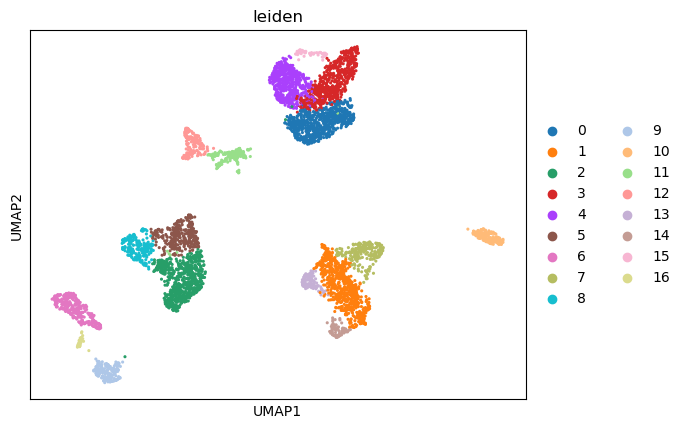

In [10]:
### clustering 
# Leiden graph-clustering method
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(OAC_pt, resolution=res)
sc.pl.umap(OAC_pt, color=["leiden"], size=20) # change colour with palette parameter

In [15]:
# set marker genes 
# cell types: Cancer cells, B cell, NK cell, T cell, monocyte, dendritic cell, lymphoid cell, macrophage, mast cell, non immune cell, adipocyte, fibroblast, pericyte, smooth muscle cell, 
# non immune cell types: adipocyte, fibroblast reticular cell, CAF, pericyte, sooth muscle cell, endothelial cell, CXC12 reticular cells, capillary resident progenitor, follicular dendritic cells, marginal reticular cell, plasma cell, perivascular cell, subscapular sinus
marker_genes = {"B cell": ["CD79A", "MS4A1", "CD19"], "NK cell": ["NCAM1", "NKG7"], "T cell": ["CD3D", "CD3E"], "Monocyte": ["FCN1", "CD14"], "Dendritic cell": ["CD1C", "FCER1A", "CLEC10A"], 
"Macrophage": ["C1QA", "CD68", "MS4A7"], "Mast cell": ["TPSAB1", "TPSB2", "CPA3"], "Cancer Associated Fibroblast": ["FAP", "ACTA2", "PDPN"], "Endothelial cell": ["PECAM1", "VWF"],
"Fibroblast": ["COL1A1", "DCN", "PDGFRA"], "Pericyte": ["PDGFRB", "RGS5"], "Smooth muscle cells": ["ACTA2", "MYH11", "TAGLN"], "Fibroblast reticular cell": ["PDPN", "CCL21"],
"Follicular dendritic cell": ["CR2", "FCER2", "CR1"], "Plasma cell": ["SDC1", "CD38", "MZB1"], "Cancer cell": ["EPCAM", "CDH1"]}
# subset to only the markers found in the data
marker_genes_in_data = {}
for ct, markers in marker_genes.items():
    markers_found = []
    for marker in markers:
        if marker in OAC_pt.var.index:
            markers_found.append(marker)
    marker_genes_in_data[ct] = markers_found


In [ ]:
"NCAM1" in OAC_pt.raw.var_names


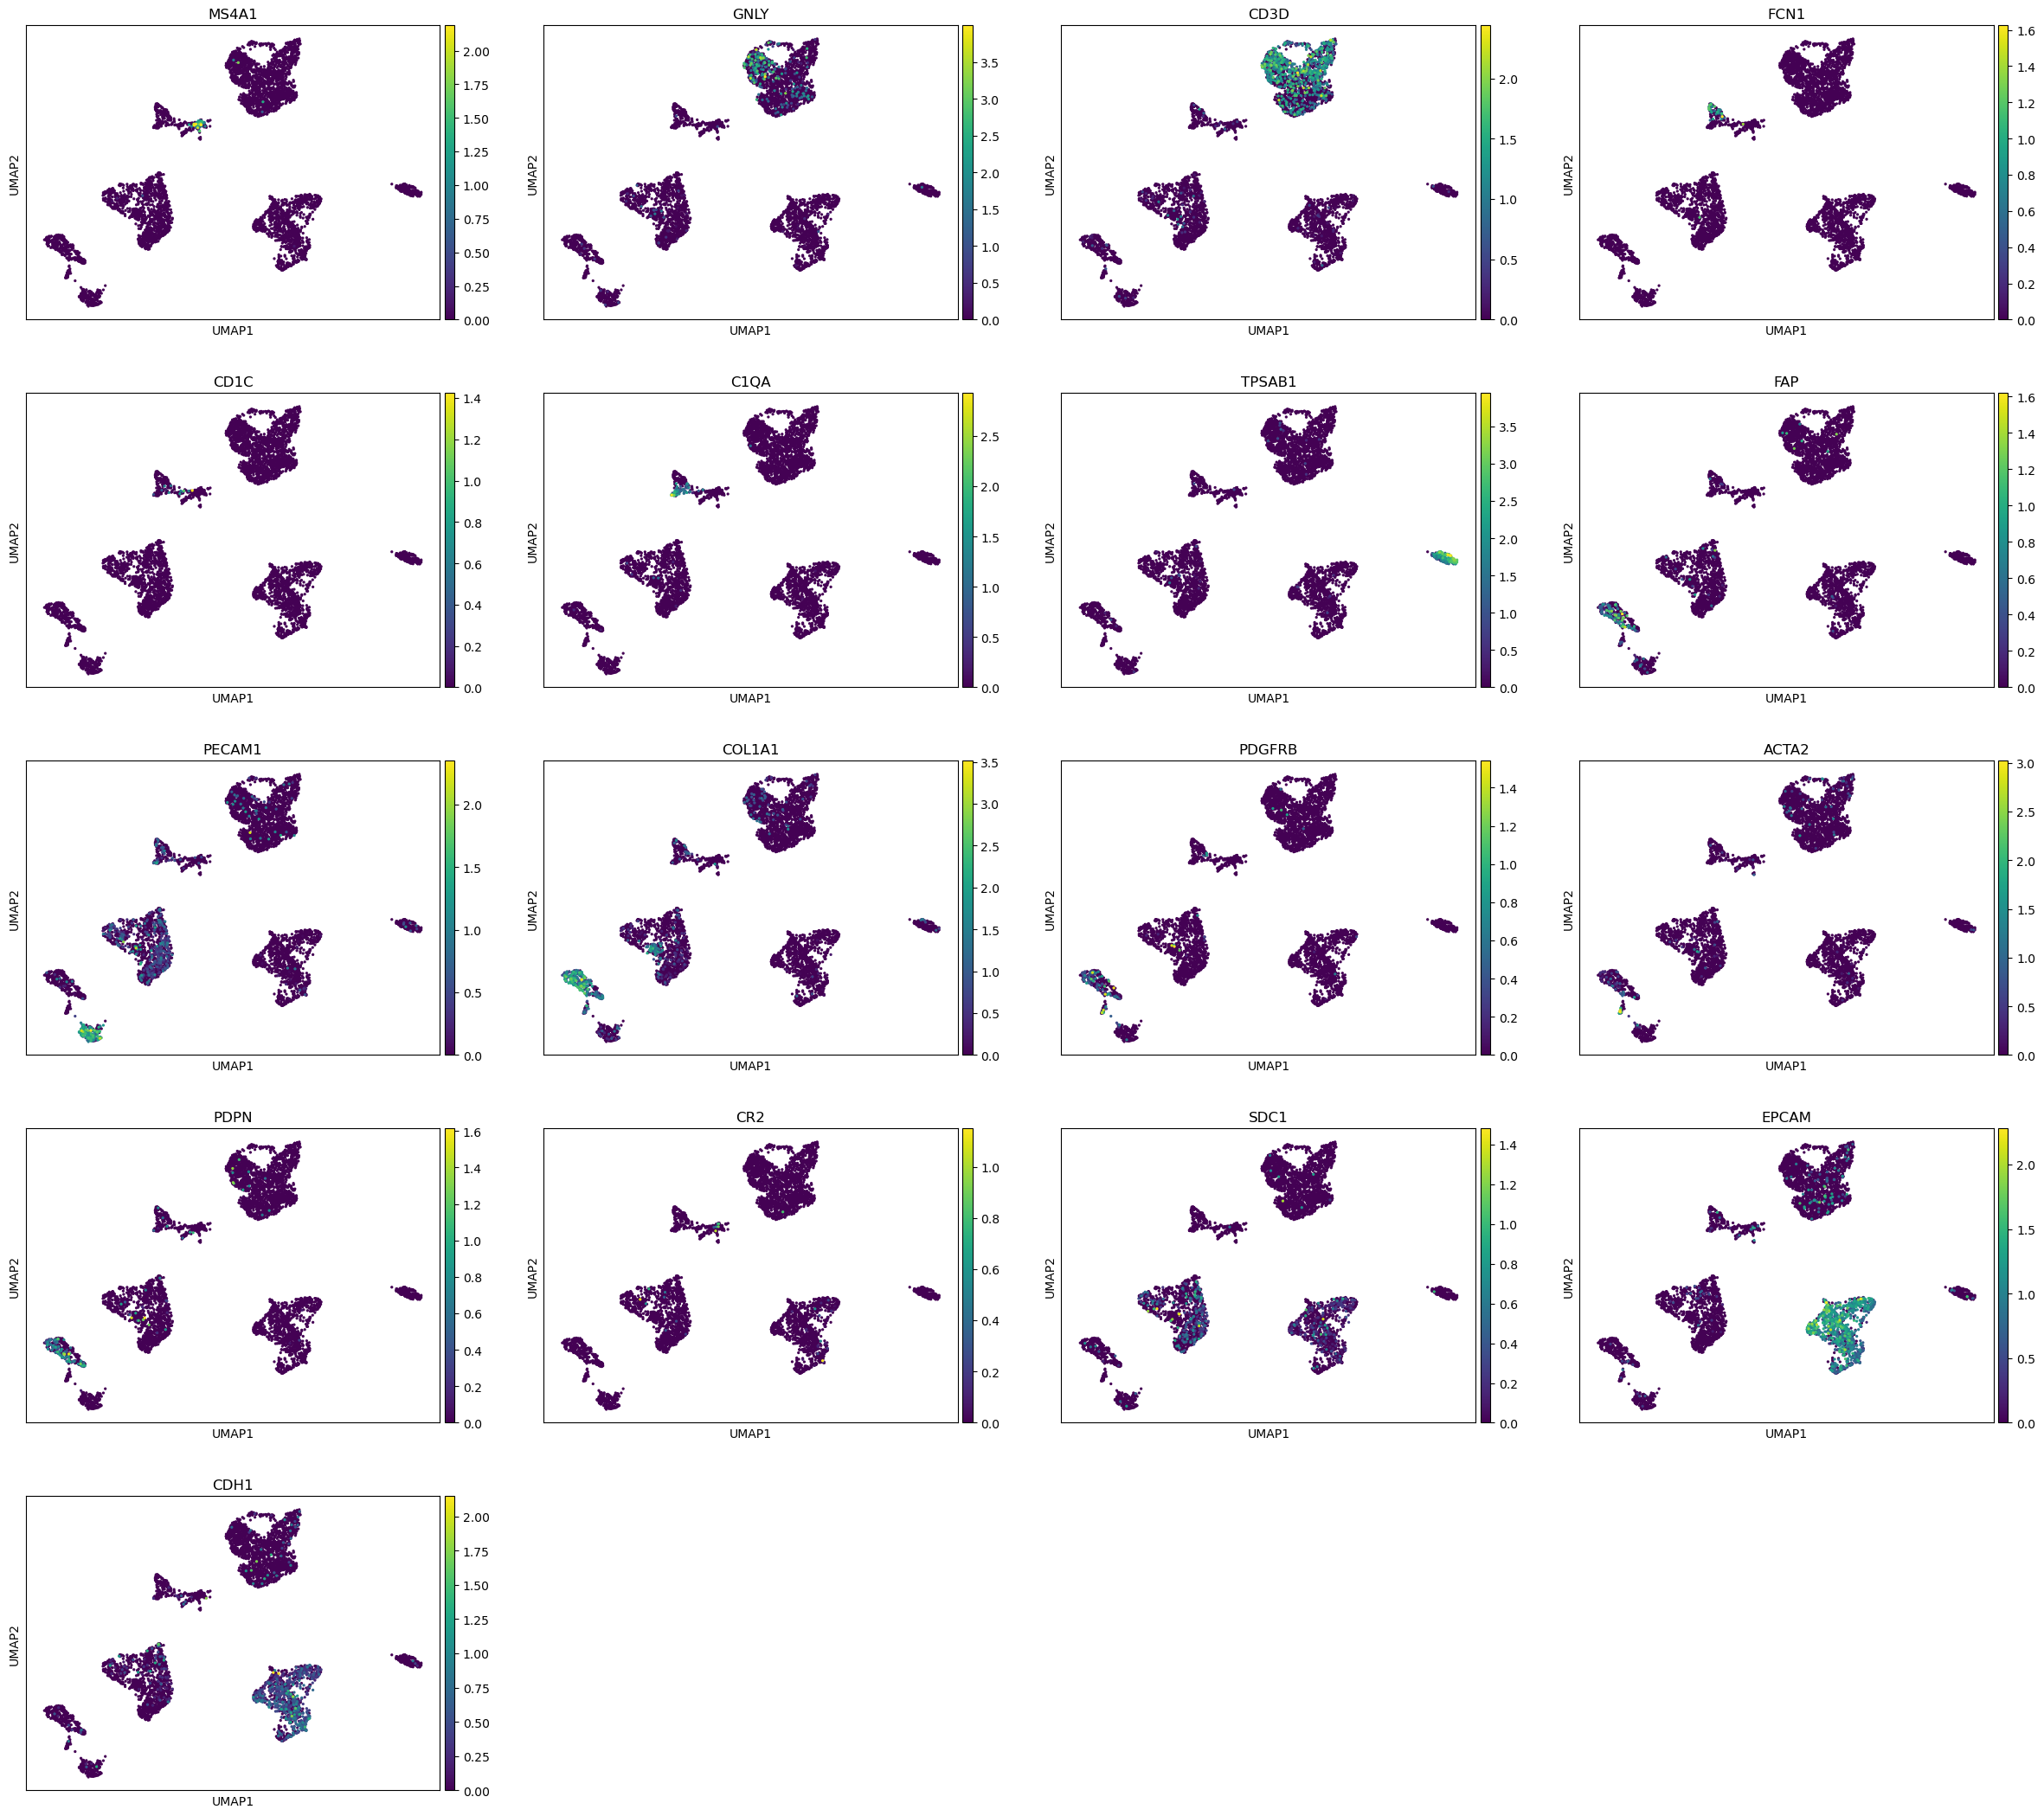

In [16]:
marker_genes_II = ["MS4A1", "GNLY", "CD3D", "FCN1", "CD1C", "C1QA", "TPSAB1", "FAP", "PECAM1", "COL1A1", "PDGFRB", "ACTA2", "PDPN", "CR2", "SDC1", "EPCAM", "CDH1"]
sc.pl.umap(OAC_pt, color=marker_genes_II, use_raw=True)

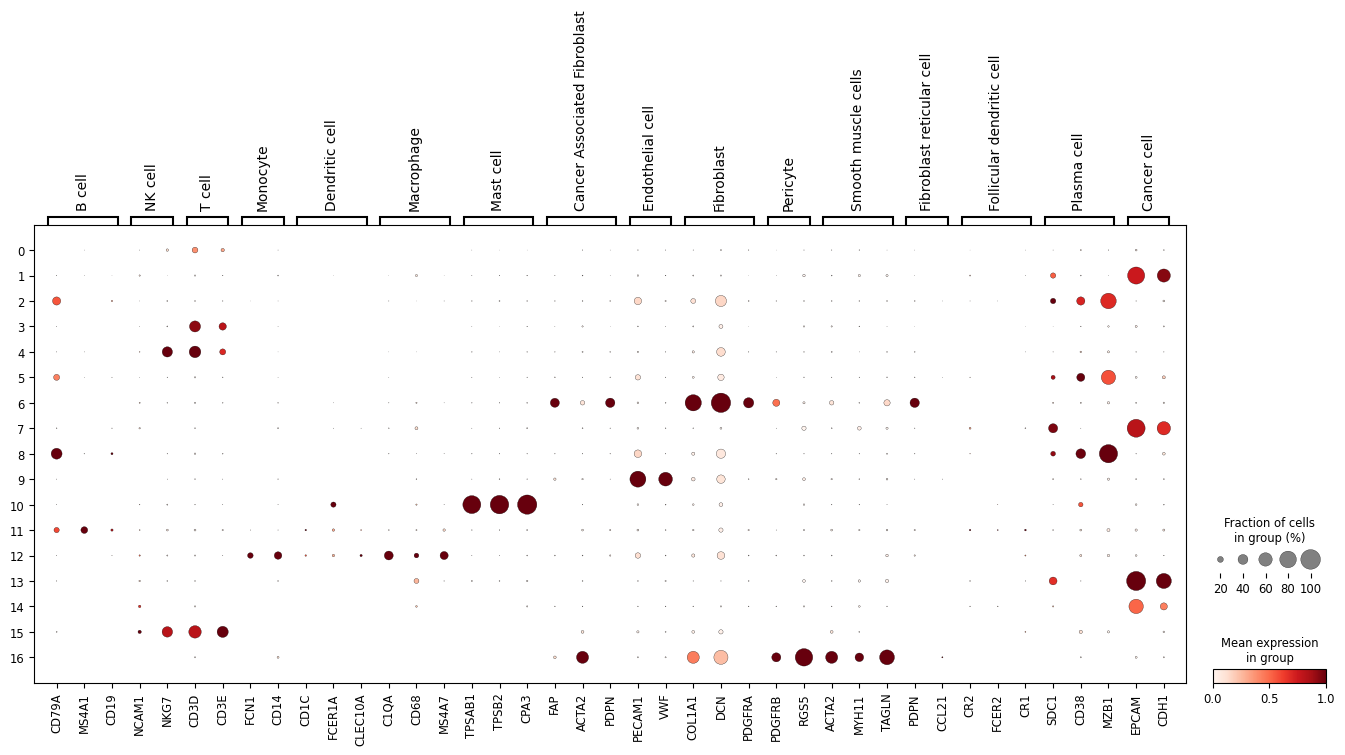

In [17]:
# Dot plot table 
sc.pl.dotplot(
    OAC_pt,
    groupby="leiden",
    var_names=marker_genes,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    use_raw=True
)

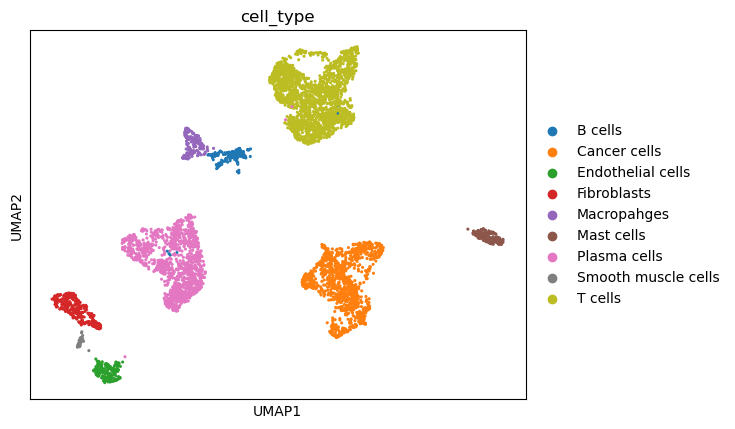

In [14]:
### Labelled UMAP
cluster_to_celltype = {
    '0': 'T cells',
    '1': 'Cancer cells',
    '2': 'Plasma cells',
    '3': 'T cells',
    '4': 'T cells',
    '5': 'Plasma cells',
    '6': 'Fibroblasts',
    '7': 'Cancer cells',
    '8': 'Plasma cells',
    '9': 'Endothelial cells',
    '10': 'Mast cells',
    '11': 'B cells',
    '12': 'Macropahges',
    '13': 'Cancer cells',
    '14': 'Cancer cells',
    '15': 'T cells',
    '16': 'Smooth muscle cells'
    # Add more as needed
}

# Create the new column
OAC_pt.obs['cell_type'] = OAC_pt.obs['leiden'].map(cluster_to_celltype)
sc.pl.umap(OAC_pt, color=["cell_type"], size=20)

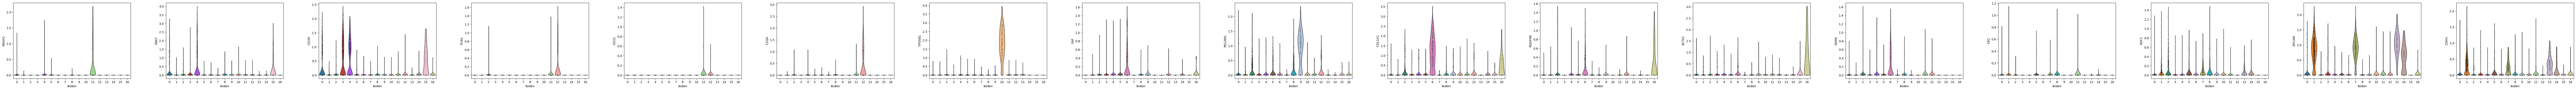

In [19]:
# Vionlin plot 
# showing the same as above
sc.pl.violin(OAC_pt, marker_genes_II, groupby='leiden')

Top 10 DE genes for cluster 0:
['CCL5' 'PTPRC' 'SRGN' 'CXCR4' 'DNAJB1' 'DNAJA1' 'HLA-B' 'TNFAIP3' 'HSPA8'
 'HLA-A' 'CREM' 'TRBC2' 'B2M' 'CD2' 'CST7' 'H3-3B' 'TMSB4X' 'UBB' 'PIK3R1'
 'CD96']


Top 10 DE genes for cluster 1:
['CD24' 'CHCHD2' 'S100A6' 'RPS12' 'AGR2' 'LYZ' 'CCT6A' 'S100P' 'TSPAN8'
 'GSTP1' 'S100A10' 'SEC61G' 'REG4' 'FTL' 'LGALS3' 'TFF1' 'NQO1' 'TFF2'
 'RPL37A' 'COX6C']


Top 10 DE genes for cluster 2:
['PABPC1' 'RPL13' 'SRGN' 'SARAF' 'IL7R' 'RPL13A' 'RPL3' 'TPT1' 'CXCR4'
 'RPL10' 'CREM' 'RPLP2' 'PTPRC' 'RPL32' 'RPS20' 'RPL19' 'RPLP1' 'EIF1'
 'RPS19' 'HLA-E']


Top 10 DE genes for cluster 3:
['CD74' 'HLA-DRA' 'MS4A1' 'CD83' 'HLA-DRB1' 'BANK1' 'HLA-DPA1' 'CD79A'
 'HLA-DQA1' 'EZR' 'CXCR4' 'BTG1' 'CD52' 'MT-CO1' 'IGKC' 'HLA-DPB1'
 'RPL13A' 'CD37' 'MT-CO3' 'RPL3']


Top 10 DE genes for cluster 4:
['ANXA2' 'S100A6' 'KRT19' 'KRT17' 'IFI27' 'KRT18' 'TM4SF1' 'KRT8' 'KRT7'
 'IER3' 'PMEPA1' 'LAMC2' 'LGALS3' 'ATP1B1' 'DSP' 'KRAS' 'EPCAM' 'S100A10'
 'ITGB1' 'S100A11']


Top 10 DE genes

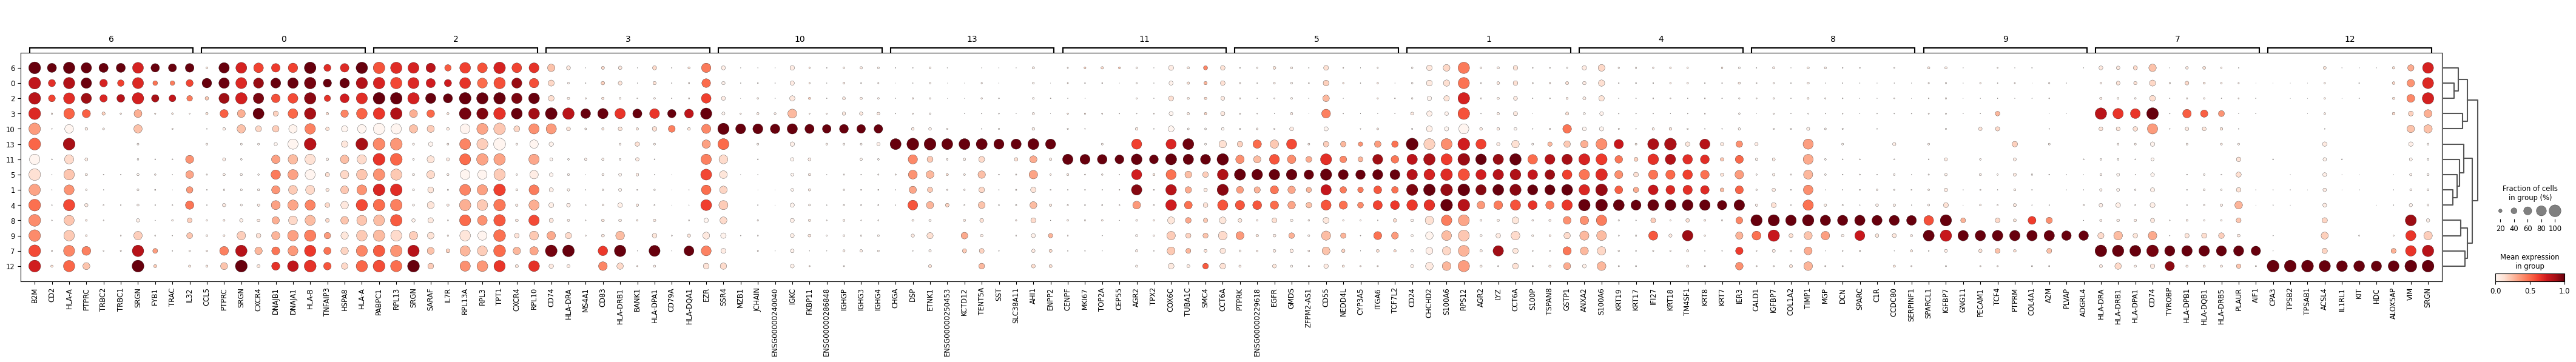

In [ ]:
# Differentially expressed genes in each cluster 
sc.tl.rank_genes_groups(
    OAC_pt, groupby="leiden", method="wilcoxon", key_added="dea_leiden"
)
# Get the result dictionary
result = OAC_pt.uns['dea_leiden']

# 'names' contains the ranked gene names per cluster
groups = result['names'].dtype.names  # cluster names

for group in groups:
    print(f"Top 10 DE genes for cluster {group}:")
    top_genes = result['names'][group][:20]
    print(top_genes)
    print("\n")
sc.pl.rank_genes_groups_dotplot(
    OAC_pt, groupby="leiden", standard_scale="var", n_genes=10, key="dea_leiden"
)

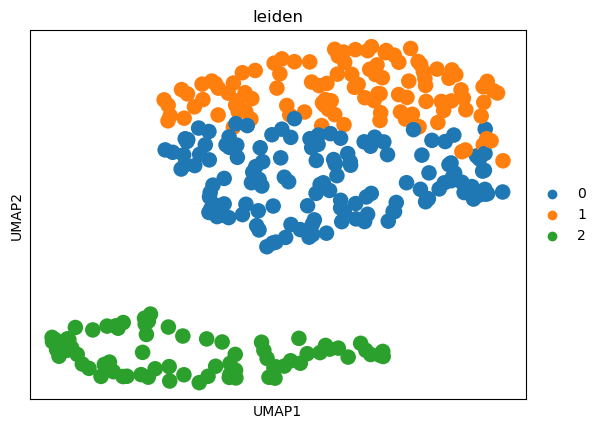

In [20]:
### subset and recluster the stromal cells 
# Create a Boolean mask for stromal clusters
fibroblast_mask = OAC_pt.obs['leiden'].isin(['6'])

# Use the mask to subset the AnnData object (this is key!)
fibroblast = OAC_pt[fibroblast_mask].copy()

# Now you can run Scanpy functions on this new AnnData object
sc.pp.neighbors(fibroblast)
sc.tl.leiden(fibroblast, resolution=0.5)
sc.tl.umap(fibroblast, min_dist=0.2)
sc.pl.umap(fibroblast, color=['leiden'], size= 500)


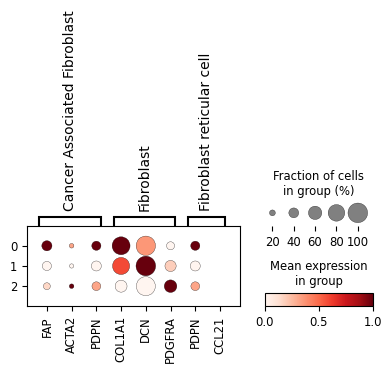

NameError: name 'stromal' is not defined

In [ ]:
### Stromal Subset cell annotation 
fibroblast_marker_genes = {"Cancer Associated Fibroblast": ["FAP", "ACTA2", "PDPN"],
"Fibroblast": ["COL1A1", "DCN", "PDGFRA"], "Fibroblast reticular cell": ["PDPN", "CCL21"]}

# dot plot 
sc.pl.dotplot(
    fibroblast,
    groupby="leiden",
    var_names=fibroblast_marker_genes,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    use_raw=True
)

# umap plots
stromal_marker_genes_II = ["FAP", "PECAM1", "COL1A1", "PDGFRB", "ACTA2", "PDPN"]
sc.pl.umap(fibroblast, color=stromal_marker_genes_II, use_raw=True)


In [ ]:
# Differentially expressed genes in each cluster 
sc.tl.rank_genes_groups(
    stromal, groupby="leiden", method="wilcoxon", key_added="dea_leiden"
)
# Get the result dictionary
result = stromal.uns['dea_leiden']

# 'names' contains the ranked gene names per cluster
groups = result['names'].dtype.names  # cluster names

for group in groups:
    print(f"Top 10 DE genes for cluster {group}:")
    top_genes = result['names'][group][:10]
    print(top_genes)
    print("\n")
sc.pl.rank_genes_groups_dotplot(
    stromal, groupby="leiden", standard_scale="var", n_genes=10, key="dea_leiden"
)

c:\Users\jh9u24\AppData\Local\r-miniconda\envs\sctoolkit_3.12\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


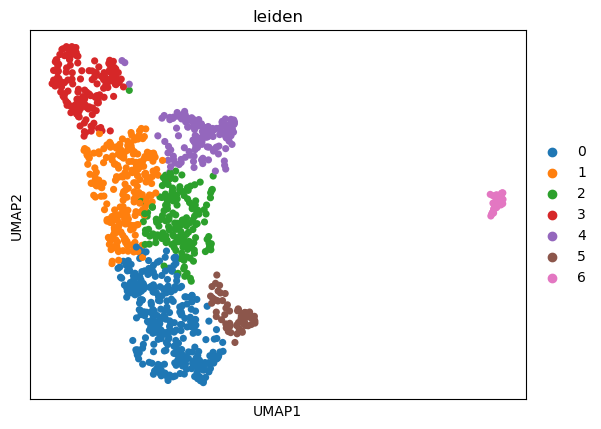

In [11]:
### subset and recluster the cancer cells 
# Create a Boolean mask for cancer clusters
cancer_mask = OAC_pt.obs['leiden'].isin(['7', '1', '14', '13'])

# Use the mask to subset the AnnData object (this is key!)
cancer = OAC_pt[cancer_mask].copy()

# Now you can run Scanpy functions on this new AnnData object
sc.pp.neighbors(cancer)
sc.tl.leiden(cancer, resolution=0.5)
sc.tl.umap(cancer, min_dist=0.2)
sc.pl.umap(cancer, color=['leiden'])


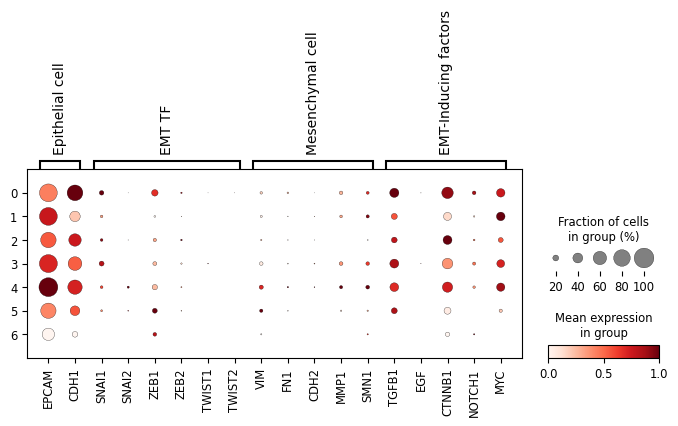

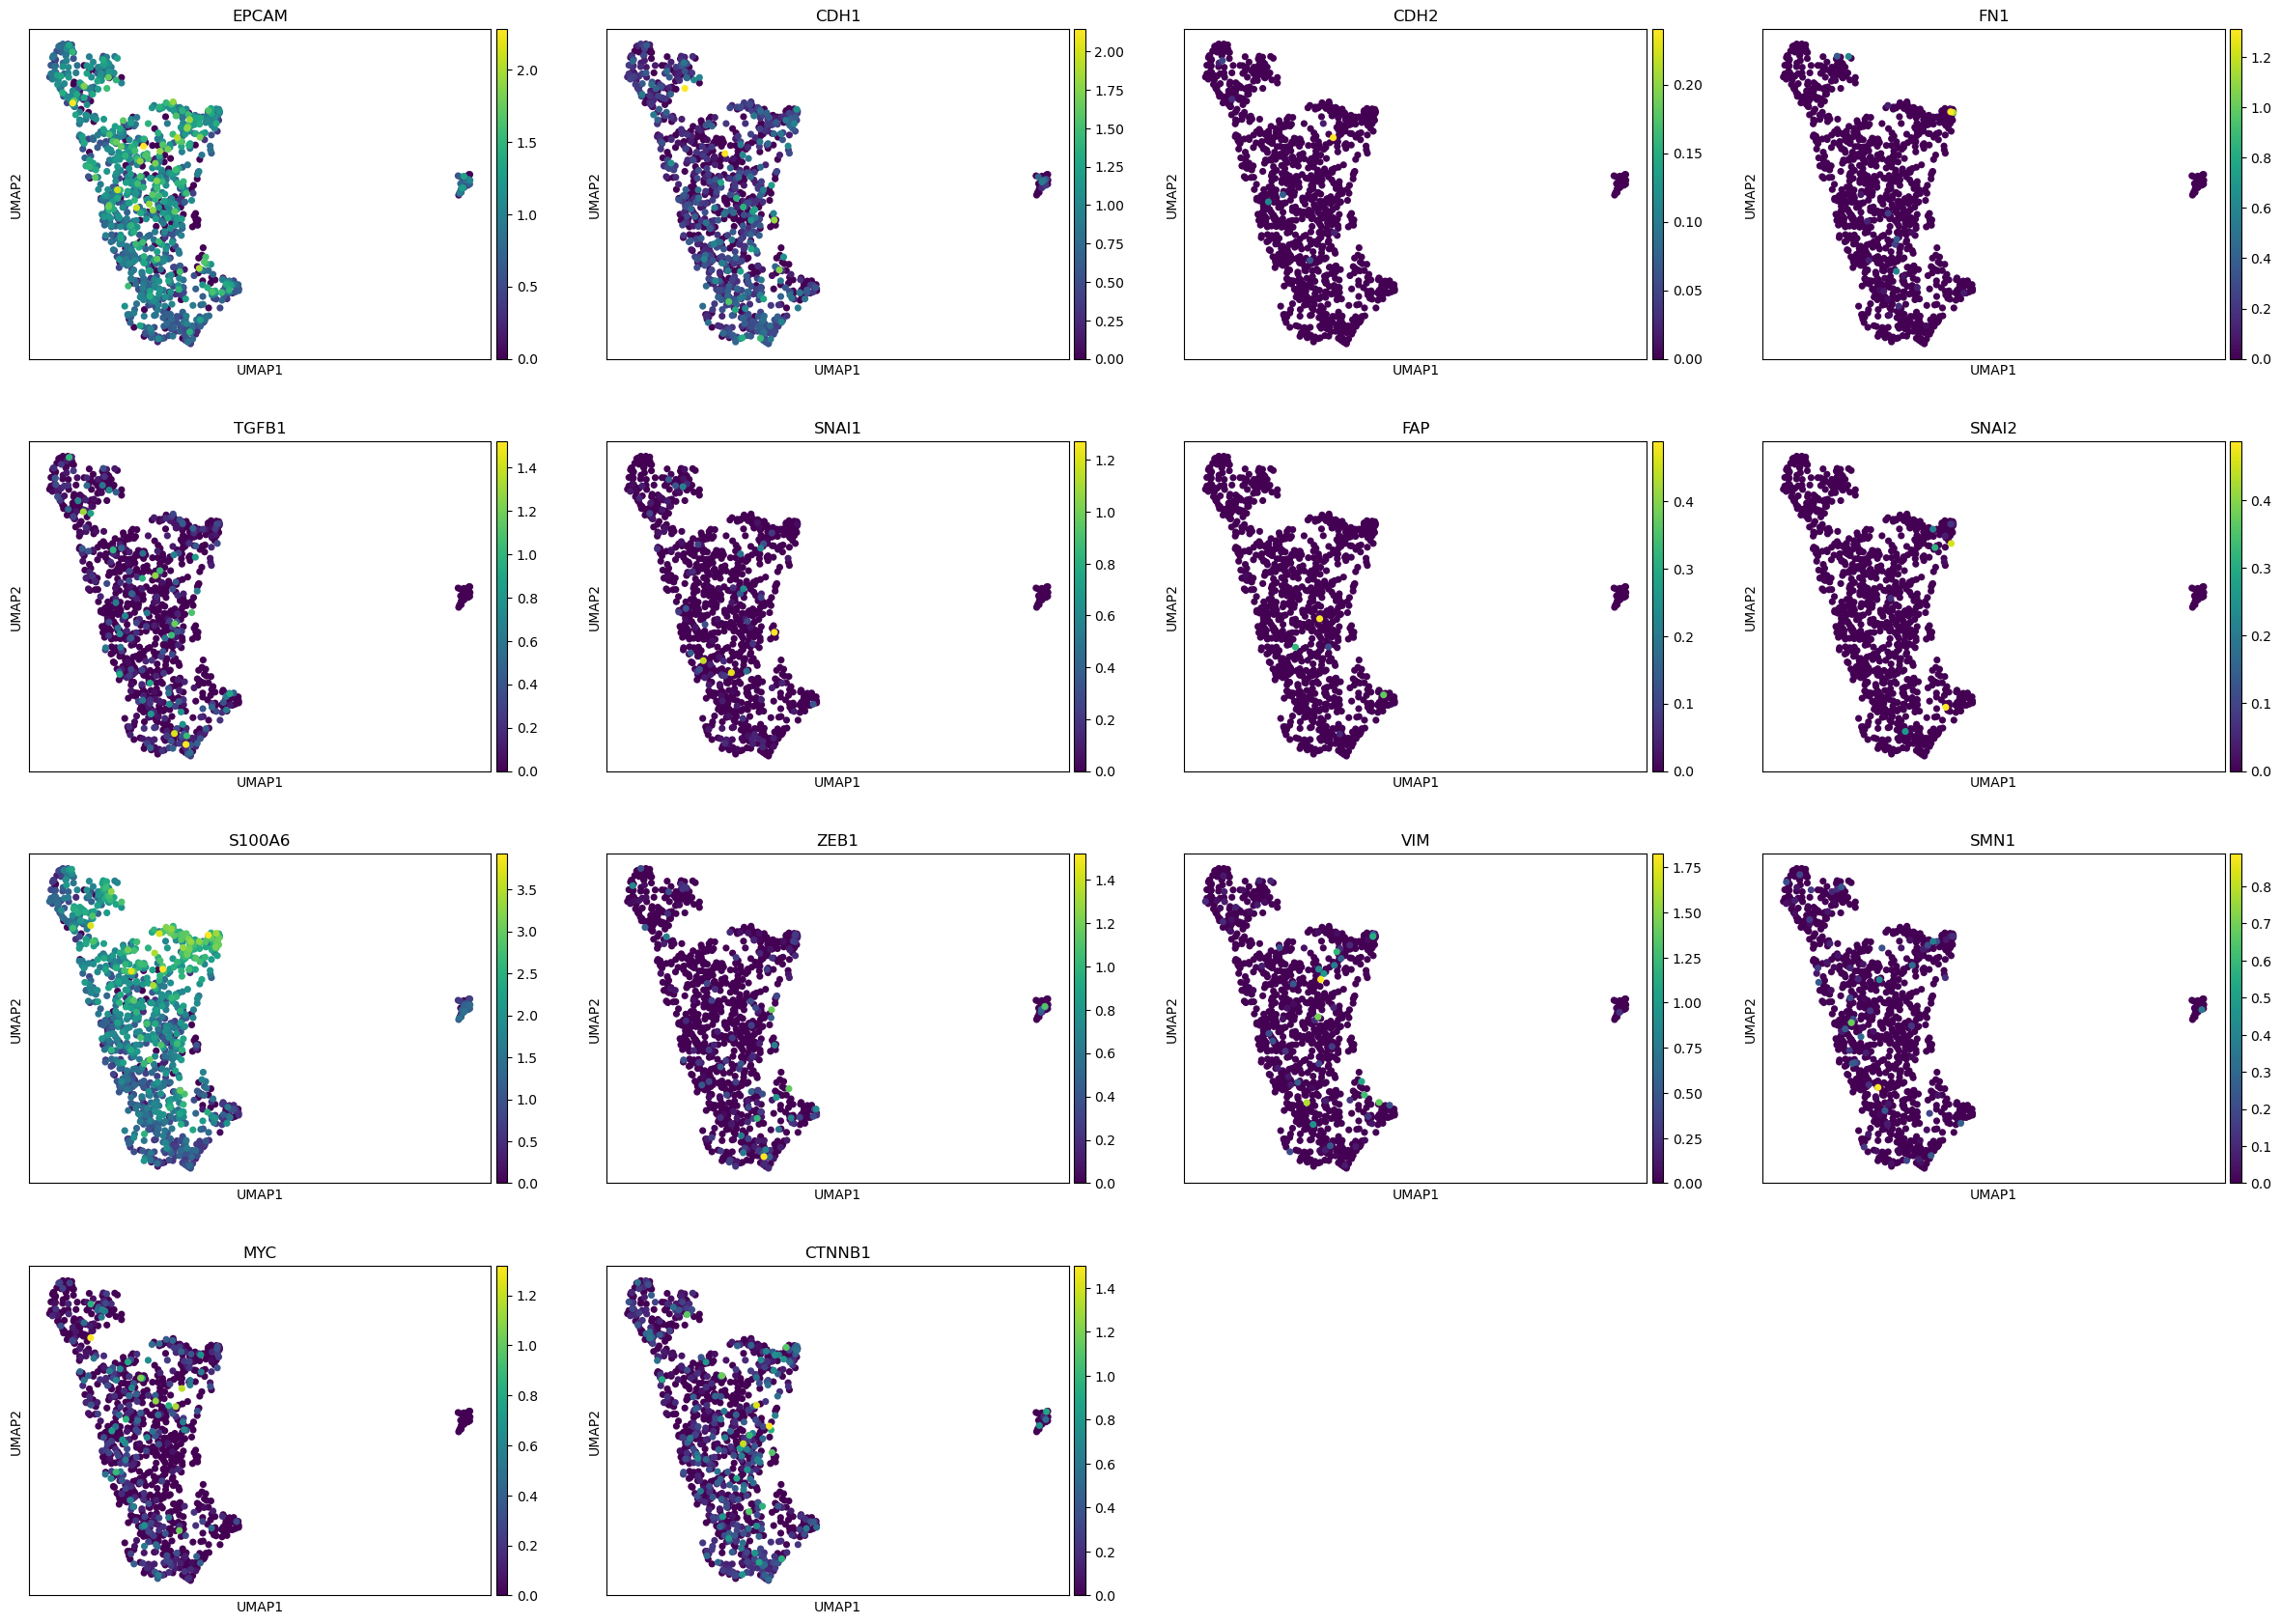

In [18]:
### Cancer Subset cell annotation 
EMT_marker_genes = {"Epithelial cell": ["EPCAM", "CDH1"], "EMT TF": ["SNAI1", "SNAI2", "ZEB1", "ZEB2", "TWIST1", "TWIST2"], "Mesenchymal cell": ["VIM", "FN1", "CDH2", "MMP1", "SMN1", ], "EMT-Inducing factors": ["TGFB1", "EGF", "CTNNB1", "NOTCH1", "MYC"] }

# dot plot 
sc.pl.dotplot(
    cancer,
    groupby="leiden",
    var_names=EMT_marker_genes,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    use_raw=True
)

# umap plots
cancer_marker_genes_II = ["EPCAM", "CDH1", "CDH2", "FN1", "TGFB1", "SNAI1", "FAP", "SNAI2", "S100A6", "ZEB1", "VIM", "SMN1", "MYC", "CTNNB1"]
sc.pl.umap(cancer, color=cancer_marker_genes_II, use_raw=True)

Top 10 DE genes for cluster 0:
['ENSG00000229618' 'CCSER1' 'SAMD12' 'PCAT1' 'GMDS' 'DLEU1' 'NSMCE2'
 'ZSWIM6' 'PLCB1' 'LINC00511' 'ENSG00000227088' 'TMEM117' 'SMYD3' 'CHRM3'
 'MECOM' 'ETNK1' 'PTPRK' 'LINC02955' 'GPHN' 'MCU']


Top 10 DE genes for cluster 1:
['RPS3' 'RPL30' 'RPS16' 'RPL13' 'RPL19' 'RPLP0' 'RPS5' 'RPS19' 'RPL27'
 'LYZ' 'RPS11' 'REG4' 'RPS8' 'RPL5' 'RPL35A' 'RPL11' 'FTL' 'RPS27A'
 'RPL7A' 'PABPC1']


Top 10 DE genes for cluster 2:
['MALAT1' 'NCOA7' 'HSP90AA1' 'RPS12' 'BCLAF1' 'HSPB1' 'AHI1' 'ATP5F1E'
 'HSPH1' 'CD24' 'RPL36' 'AKAP13' 'HSPA1B' 'ENSG00000306248' 'EGR1'
 'ENSG00000234147' 'AREG' 'DDX21' 'GHRL' 'HSP90AB1']


Top 10 DE genes for cluster 3:
['MKI67' 'HMGB2' 'TOP2A' 'CENPF' 'TPX2' 'TUBA1B' 'ASPM' 'SMC4' 'CEP55'
 'ANLN' 'DLGAP5' 'STMN1' 'UBE2C' 'NUF2' 'KIF20B' 'CENPE' 'AURKA' 'H2AZ1'
 'RAD21' 'ANP32E']


Top 10 DE genes for cluster 4:
['S100A6' 'B2M' 'TM4SF1' 'KRT19' 'KRT7' 'HLA-B' 'ANXA2' 'FTH1' 'TMSB10'
 'HLA-A' 'HLA-C' 'C19orf33' 'ANXA1' 'IFI27' 'AKAP12' 'TMSB4

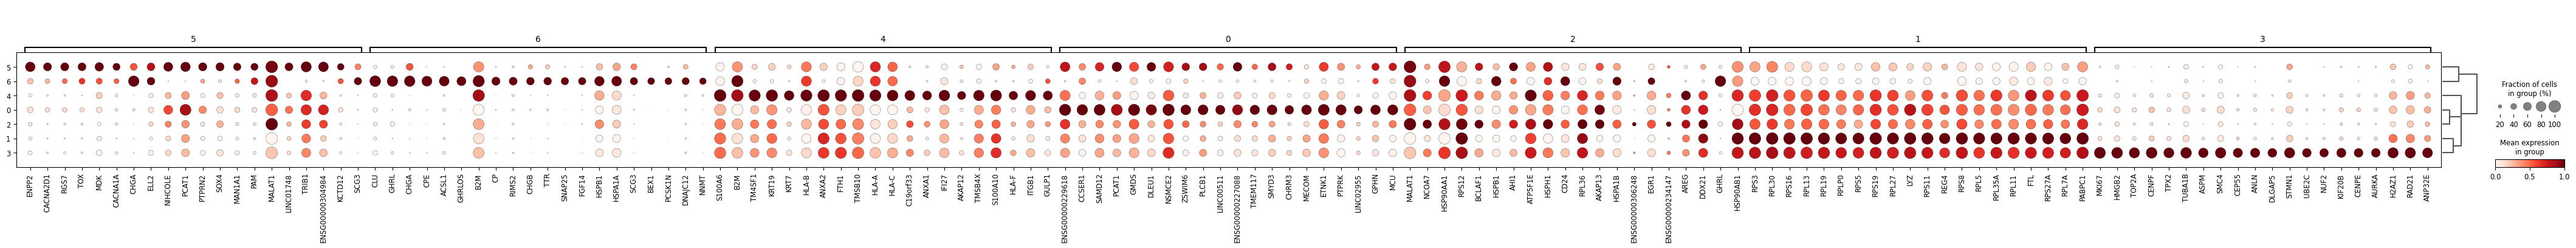

In [24]:
# Differentially expressed genes in each cluster 
sc.tl.rank_genes_groups(
    cancer, groupby="leiden", method="wilcoxon", key_added="dea_leiden"
)
# Get the result dictionary
result = cancer.uns['dea_leiden']

# 'names' contains the ranked gene names per cluster
groups = result['names'].dtype.names  # cluster names

for group in groups:
    print(f"Top 10 DE genes for cluster {group}:")
    top_genes = result['names'][group][:20]
    print(top_genes)
    print("\n")
sc.pl.rank_genes_groups_dotplot(
    cancer, groupby="leiden", standard_scale="var", n_genes=20, key="dea_leiden"
)

In [ ]:
# Manual cell type annotation notes
# plot umaps and the expression of every marker gene known to man 
# dot plot also works
# violin plot 
# cluster with broad cell types - once happy extract CAFs fro example and recluster to look for more specific subsets
# start broad 
# then maybe make a CAF specific one 


In [2]:
### Cellphone Db
# download database from source
# display database versions 
from IPython.display import HTML, display
from cellphonedb.utils import db_releases_utils

display(HTML(db_releases_utils.get_remote_database_versions_html()['db_releases_html_table']))

In [3]:
# define version and path and then download db
# -- Version of the databse
cpdb_version = 'v5.0.0'

# -- Path where the input files to generate the database are located
cpdb_target_dir = os.path.join('C:/Users/jh9u24/OneDrive - University of Southampton/University/MRes/RPC/sc_analysis/Cellphonedb', cpdb_version)
# download
from cellphonedb.utils import db_utils
db_utils.download_database(cpdb_target_dir, cpdb_version)

Downloaded cellphonedb.zip into C:/Users/jh9u24/OneDrive - University of Southampton/University/MRes/RPC/sc_analysis/Cellphonedb\v5.0.0
Downloaded complex_input.csv into C:/Users/jh9u24/OneDrive - University of Southampton/University/MRes/RPC/sc_analysis/Cellphonedb\v5.0.0
Downloaded gene_input.csv into C:/Users/jh9u24/OneDrive - University of Southampton/University/MRes/RPC/sc_analysis/Cellphonedb\v5.0.0
Downloaded interaction_input.csv into C:/Users/jh9u24/OneDrive - University of Southampton/University/MRes/RPC/sc_analysis/Cellphonedb\v5.0.0
Downloaded protein_input.csv into C:/Users/jh9u24/OneDrive - University of Southampton/University/MRes/RPC/sc_analysis/Cellphonedb\v5.0.0
Downloaded uniprot_synonyms.tsv into C:/Users/jh9u24/OneDrive - University of Southampton/University/MRes/RPC/sc_analysis/Cellphonedb\v5.0.0\sources
Downloaded transcription_factor_input.csv into C:/Users/jh9u24/OneDrive - University of Southampton/University/MRes/RPC/sc_analysis/Cellphonedb\v5.0.0\sources


In [19]:
# make the file requirements 
print(OAC_met.obs.head())
print(OAC_met.obs.columns)


               sample  n_genes_by_counts  log1p_n_genes_by_counts  \
CTTCCGATTAAC  OAC26_M               7096                 8.867427   
CCACTATCATGG  OAC26_M               6944                 8.845777   
TAGATCCATCTG  OAC26_M               5236                 8.563504   
GACTTGTTTTGA  OAC26_M               4775                 8.471359   
TTTGGCTATGAC  OAC26_M               4634                 8.441391   

              total_counts  log1p_total_counts  pct_counts_in_top_50_genes  \
CTTCCGATTAAC         25239           10.136185                   20.266255   
CCACTATCATGG         24675           10.113586                   23.278622   
TAGATCCATCTG         15354            9.639196                   18.262342   
GACTTGTTTTGA         14209            9.561701                   21.064114   
TTTGGCTATGAC         13651            9.521641                   21.082705   

              pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
CTTCCGATTAAC                    26.997900 

In [ ]:
# make the file requirements 

meta_df = pd.DataFrame({
    "Cell": OAC_met.obs_names,
    "cell_type": OAC_met.obs["cell_type"]  # or whatever the column is named
})
meta_df.to_csv("C:/Users/jh9u24/OneDrive - University of Southampton/University/MRes/RPC/sc_analysis/Cellphonedb/OAC_met_meta.txt", sep="\t", index=False)

# set file paths 
cpdb_file_path = "C:/Users/jh9u24/OneDrive - University of Southampton/University/MRes/RPC/sc_analysis/Cellphonedb/v5.0.0/cellphonedb.zip"
meta_file_path = "C:/Users/jh9u24/OneDrive - University of Southampton/University/MRes/RPC/sc_analysis/Cellphonedb/OAC_met_meta.txt"
out_file_path = "C:/Users/jh9u24/OneDrive - University of Southampton/University/MRes/RPC/sc_analysis/Cellphonedb/out"

In [ ]:
# Run cellphone db on all the data 
from cellphonedb.src.core.methods import cpdb_analysis_method

cpdb_results = cpdb_analysis_method.call(
    cpdb_file_path =cpdb_file_path,           # Example: "cellphonedb/data/cellphonedb.zip"
    meta_file_path = meta_file_path,             # Contains: Cell\tcell_type
    counts_file_path = OAC_met,        # AnnData file with expression matrix
    counts_data = "hgnc_symbol",                  # Gene symbols must match CPDB format
    output_path = out_file_path                      # Output folder path (e.g. "./cpdb_out/")
)

[ ][CORE][17/06/25-14:21:56][INFO] [Non Statistical Method] Threshold:0.1 Precision:3
Reading user files...
The following user files were loaded successfully:
counts from AnnData object
C:/Users/jh9u24/OneDrive - University of Southampton/University/MRes/RPC/sc_analysis/Cellphonedb/OAC_met_meta.txt


c:\Users\jh9u24\AppData\Local\r-miniconda\envs\sctoolkit_3.12\Lib\site-packages\cellphonedb\src\core\models\complex\complex_helper.py:40: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  complex_to_protein_ids = complex_composition.groupby(COMPLEX_ID).apply(lambda x: x[PROTEIN_ID].values).to_dict()


[ ][CORE][17/06/25-14:21:57][INFO] Running Basic Analysis
[ ][CORE][17/06/25-14:21:57][INFO] Building results
Saved means_result to C:/Users/jh9u24/OneDrive - University of Southampton/University/MRes/RPC/sc_analysis/Cellphonedb/out\simple_analysis_means_result_06_17_2025_142157.txt
Saved deconvoluted to C:/Users/jh9u24/OneDrive - University of Southampton/University/MRes/RPC/sc_analysis/Cellphonedb/out\simple_analysis_deconvoluted_06_17_2025_142157.txt
Saved deconvoluted_percents to C:/Users/jh9u24/OneDrive - University of Southampton/University/MRes/RPC/sc_analysis/Cellphonedb/out\simple_analysis_deconvoluted_percents_06_17_2025_142157.txt
